#📌 Extracão

In [1]:
import pandas as pd

apiTelecomX = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json"
dados_TelecomX = pd.read_json(apiTelecomX)
dados_TelecomX.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


#🔧 Transformação

#### Dicionário de dados

* `customerID`: número de identificação único de cada cliente
* `Churn`: se o cliente deixou ou não a empresa
* `gender`: gênero (masculino e feminino)
* `SeniorCitizen`: informação sobre um cliente ter ou não idade igual ou maior que 65 anos
* `Partner`:  se o cliente possui ou não um parceiro ou parceira
* `Dependents`: se o cliente possui ou não dependentes
* `tenure`:  meses de contrato do cliente
* `PhoneService`: assinatura de serviço telefônico
* `MultipleLines`: assisnatura de mais de uma linha de telefone
* `InternetService`: assinatura de um provedor internet
* `OnlineSecurity`: assinatura adicional de segurança online
* `OnlineBackup`: assinatura adicional de backup online
* `DeviceProtection`: assinatura adicional de proteção no dispositivo
* `TechSupport`: assinatura adicional de suporte técnico, menos tempo de espera
* `StreamingTV`: assinatura de TV a cabo
* `StreamingMovies`: assinatura de streaming de filmes
* `Contract`: tipo de contrato
* `PaperlessBilling`: se o cliente prefere receber online a fatura
* `PaymentMethod`: forma de pagamento
* `Charges.Monthly`: total de todos os serviços do cliente por mês
* `Charges.Total`: total gasto pelo cliente

In [7]:
# 1. Normalizando o DataFrame aninhado da primeira célula
# Explicitly normalize the nested 'customer', 'phone', 'internet', and 'account' dictionaries
df_clientes = pd.json_normalize(
    dados_TelecomX.to_dict('records'),
    meta=['customerID', 'Churn'],
    record_path=['customer'],
    meta_prefix='customer.',
    sep='_'
)

df_phone = pd.json_normalize(
    dados_TelecomX.to_dict('records'),
    record_path=['phone'],
    meta_prefix='phone.',
    sep='_'
)

df_internet = pd.json_normalize(
    dados_TelecomX.to_dict('records'),
    record_path=['internet'],
    meta_prefix='internet.',
    sep='_'
)

df_account = pd.json_normalize(
    dados_TelecomX.to_dict('records'),
    record_path=['account'],
    meta_prefix='account.',
    sep='_'
)

# Concatenate the normalized dataframes
df_clientes = pd.concat([df_clientes, df_phone, df_internet, df_account], axis=1)


# 2. Corrigindo a coluna 'Charges.Total' para ser numérica
# The column contains spaces that make it text. We convert it to a number.
# Access the column using the correct key
df_clientes['account_Charges_Total'] = pd.to_numeric(df_clientes['account_Charges_Total'], errors='coerce')
df_clientes.fillna({'account_Charges_Total': 0}, inplace=True)


# 3. Creating the 'Contas_Diarias' column
# We calculate the daily value by dividing the monthly value by 30.
df_clientes['Contas_Diarias'] = df_clientes['account_Charges_Monthly'] / 30

# 4. Standardizing column names to remove prefixes
# The normalization with sep='_' already created names like 'customer_gender', 'account_Charges_Total', etc.
# We can now rename them to the desired format without the prefixes if needed, or keep them as is.
# For consistency with the original dictionary, let's rename them to remove the prefixes.
# Create a dictionary for renaming
rename_dict = {}
for col in df_clientes.columns:
    if '_' in col:
        # Assuming the format is 'prefix_columnname'
        parts = col.split('_', 1)
        if len(parts) > 1:
            rename_dict[col] = parts[1]

df_clientes.rename(columns=rename_dict, inplace=True)

# Manually correct any remaining specific column name issues if necessary
# Based on the data dictionary, 'tenure' should be just 'tenure', not 'customer_tenure'
# Also 'Charges.Monthly' and 'Charges.Total' should have a dot, not underscore, if preferred.
# Let's rename them to match the data dictionary exactly.
df_clientes.rename(columns={'customer_tenure': 'tenure',
                           'account_Charges_Monthly': 'Charges.Monthly',
                           'account_Charges_Total': 'Charges.Total'}, inplace=True)


# 5. Standardizing 'Yes' and 'No' data to 1 and 0
colunas_para_ajustar = ['Churn', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'] # Added more columns based on the data dictionary
for coluna in colunas_para_ajustar:
    if coluna in df_clientes.columns:
        df_clientes[coluna] = df_clientes[coluna].replace({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0}) # Added more replacements for other columns


# 6. Displaying the final transformation result
print("✅ Transformação concluída! O DataFrame 'df_clientes' está limpo e pronto para a análise.")
display(df_clientes.head())

# Opcional: display a summary of the final structure for verification
print("\nEstrutura final do DataFrame:")
df_clientes.info()

✅ Transformação concluída! O DataFrame 'df_clientes' está limpo e pronto para a análise.


/tmp/ipython-input-1798248479.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clientes[coluna] = df_clientes[coluna].replace({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0}) # Added more replacements for other columns


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Contas_Diarias
0,0002-ORFBO,0,Female,0,1,1,9,1,No,DSL,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0,Male,0,0,0,9,1,Yes,DSL,...,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1,Male,0,0,0,4,1,No,Fiber optic,...,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1,Male,1,1,0,13,1,No,Fiber optic,...,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1,Female,1,1,0,3,1,No,Fiber optic,...,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.796667



Estrutura final do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   int64  
 5   Dependents        7267 non-null   int64  
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   int64  
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   int64  
 11  OnlineBackup      7267 non-null   int64  
 12  DeviceProtection  7267 non-null   int64  
 13  TechSupport       7267 non-null   int64  
 14  StreamingTV       7267 non-null   int64  
 15  StreamingMovies   7267 non-null   int64  
 16  Contract   

#📊 Carga e análise


[1/5] Resumo Estatístico dos Dados Numéricos:


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Charges.Monthly,Charges.Total,Contas_Diarias
count,7267.00,7267.00,7267.00,7267.00,7267.0,7267.00,7267.00,7267.00,7267.00,7267.00,7267.00,7267.00,7267.00,7267.00,7267.00
mean,0.16,0.48,0.30,32.35,0.9,0.29,0.34,0.34,0.29,0.38,0.39,0.59,64.72,2277.18,2.16
std,0.37,0.50,0.46,24.57,0.3,0.45,0.48,0.47,0.45,0.49,0.49,0.49,30.13,2268.65,1.00
min,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.25,0.00,0.61
25%,0.00,0.00,0.00,9.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,35.42,396.20,1.18
50%,0.00,0.00,0.00,29.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,70.30,1389.20,2.34
75%,0.00,1.00,1.00,55.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,89.88,3778.52,3.00
max,1.00,1.00,1.00,72.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,118.75,8684.80,3.96



[2/5] Analisando a Distribuição de Churn (Evasão de Clientes):


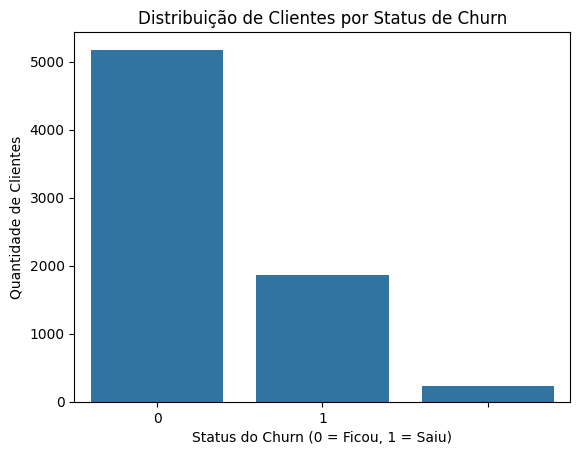


[3/5] Analisando o Churn por Variáveis Categóricas:


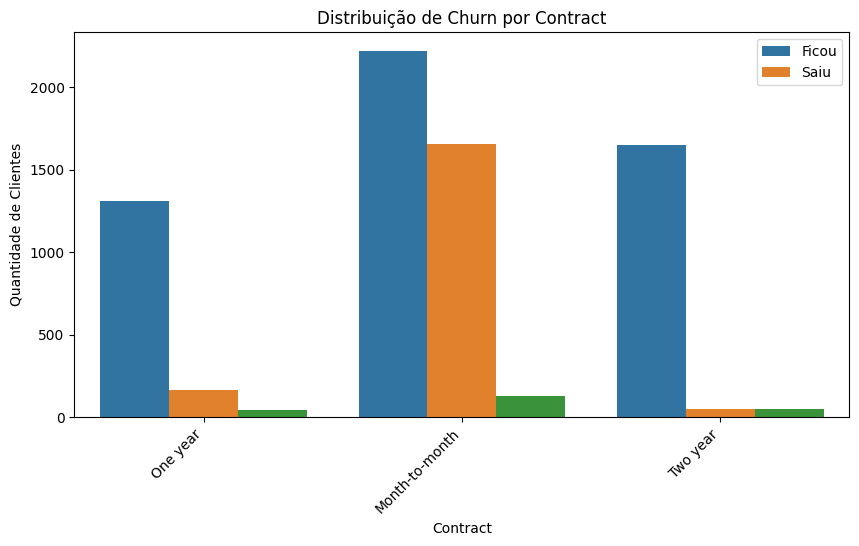

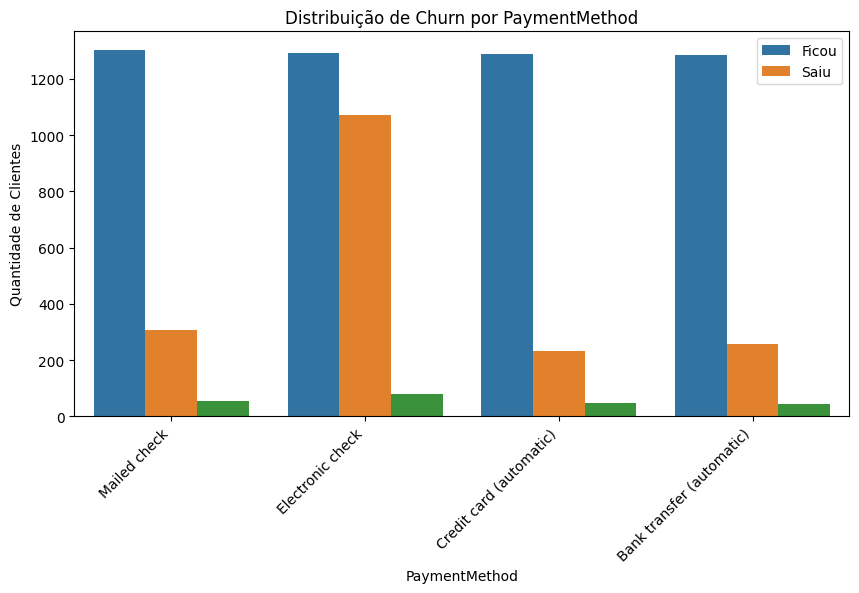

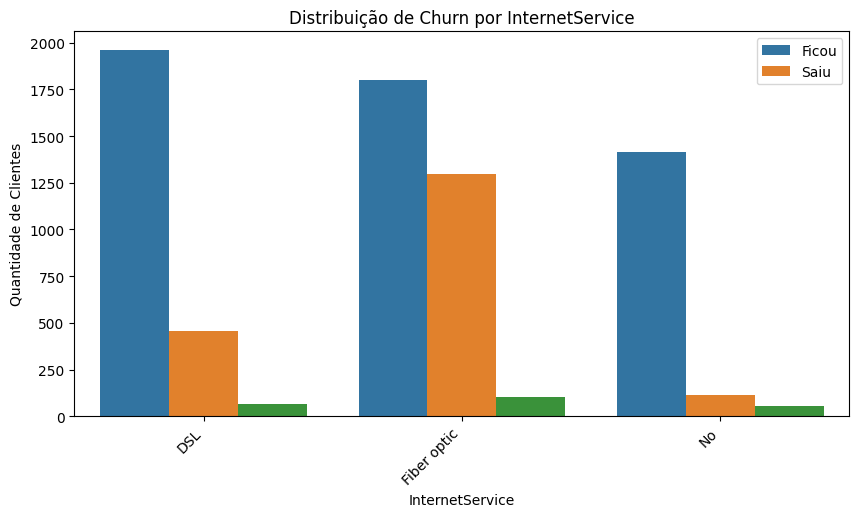


[4/5] Analisando o Churn por Variáveis Numéricas:


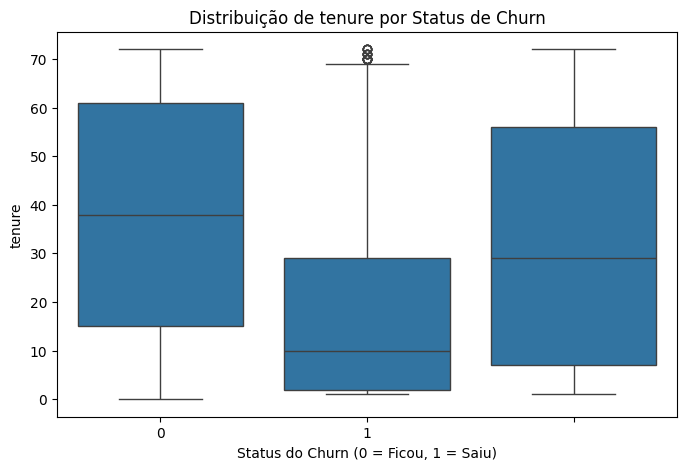

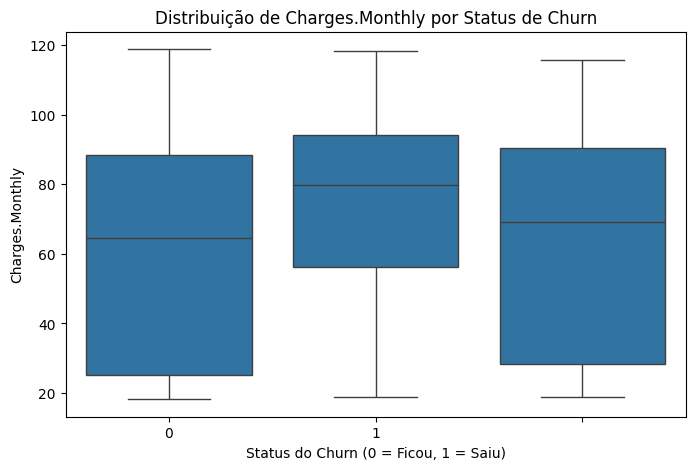

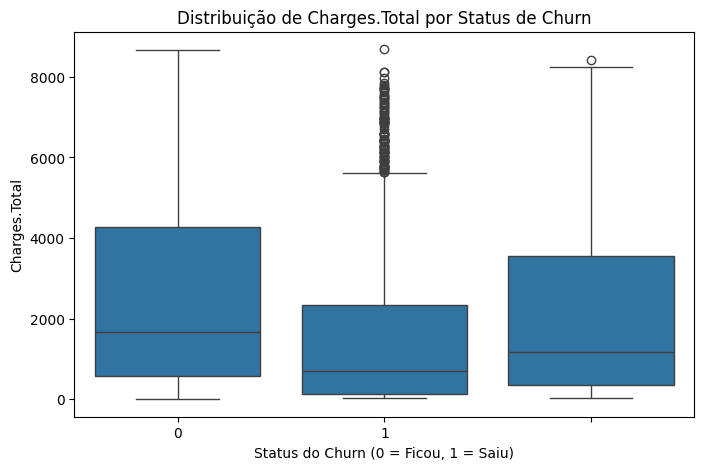


[5/5] Analisando a Correlação entre as Variáveis:


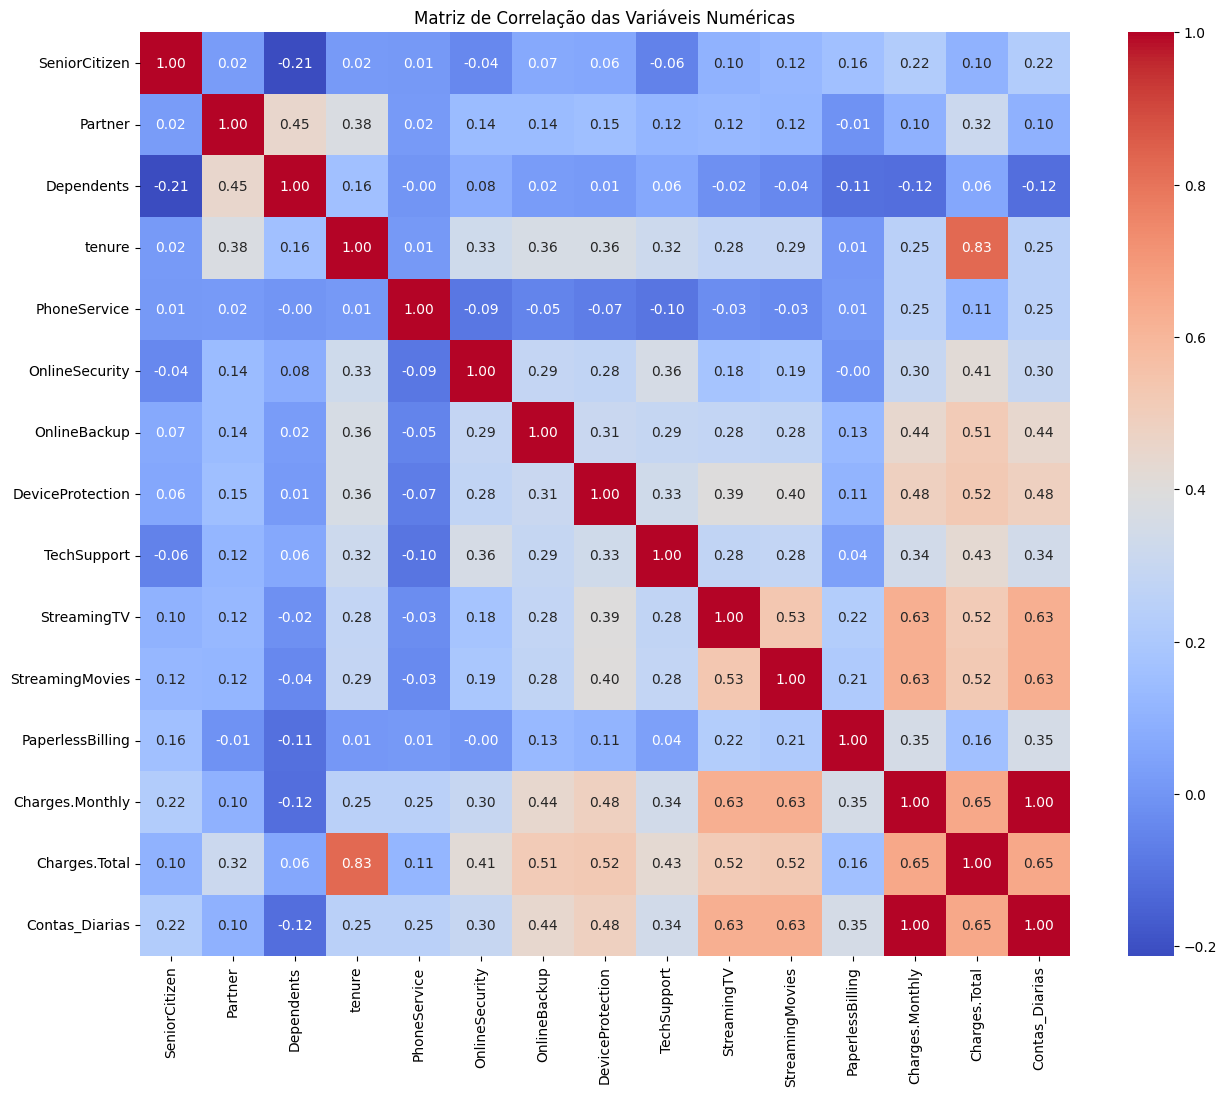


✅ Análise Exploratória Concluída!


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Análise Descritiva Geral ---
# O método .describe() nos dá um resumo estatístico das colunas numéricas.
print("\n[1/5] Resumo Estatístico dos Dados Numéricos:")
# Usamos .round(2) para deixar a visualização dos números mais limpa.
display(df_clientes.describe().round(2))


# --- 2. Análise da Variável Alvo (Churn) ---
print("\n[2/5] Analisando a Distribuição de Churn (Evasão de Clientes):")
# Usamos um gráfico de contagem (countplot) para ver a proporção de clientes que saíram (1) e que ficaram (0).
sns.countplot(x='Churn', data=df_clientes)
plt.title('Distribuição de Clientes por Status de Churn')
plt.xlabel('Status do Churn (0 = Ficou, 1 = Saiu)')
plt.ylabel('Quantidade de Clientes')
plt.show()


# --- 3. Análise Categórica (Como o Churn se Comporta em Diferentes Grupos) ---
print("\n[3/5] Analisando o Churn por Variáveis Categóricas:")
# Vamos analisar 3 variáveis categóricas importantes: Contrato, Forma de Pagamento e Serviço de Internet.
colunas_categoricas = ['Contract', 'PaymentMethod', 'InternetService']

for coluna in colunas_categoricas:
    plt.figure(figsize=(10, 5)) # Cria uma nova figura para cada gráfico
    sns.countplot(x=coluna, hue='Churn', data=df_clientes)
    plt.title(f'Distribuição de Churn por {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Quantidade de Clientes')
    plt.xticks(rotation=45, ha='right') # Rotaciona os rótulos para não sobrepor
    plt.legend(['Ficou', 'Saiu'])
    plt.show()


# --- 4. Análise Numérica (Como Variáveis Numéricas se Comportam em Relação ao Churn) ---
print("\n[4/5] Analisando o Churn por Variáveis Numéricas:")
# Usamos gráficos de caixa (boxplot) para comparar a distribuição de valores.
colunas_numericas = ['tenure', 'Charges.Monthly', 'Charges.Total'] # Corrected column names

for coluna in colunas_numericas:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Churn', y=coluna, data=df_clientes)
    plt.title(f'Distribuição de {coluna} por Status de Churn')
    plt.xlabel('Status do Churn (0 = Ficou, 1 = Saiu)')
    plt.ylabel(coluna)
    plt.show()


# --- 5. Análise de Correlação ---
print("\n[5/5] Analisando a Correlação entre as Variáveis:")
# A matriz de correlação mostra como as variáveis numéricas se relacionam entre si.
# Valores próximos de 1 ou -1 indicam uma correlação forte.
plt.figure(figsize=(15, 12))
# Criamos o mapa de calor (heatmap) para visualizar a matriz.
sns.heatmap(df_clientes.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()

print("\n✅ Análise Exploratória Concluída!")

#📄Relatorio Final

# 📊 Relatório de Análise de Churn de Clientes - Telecom X

**Projeto:** Análise Exploratória de Dados sobre a Evasão de Clientes

---

### **1. Introdução**

A Telecom X enfrenta um desafio crítico para seu crescimento sustentável: um alto índice de evasão de clientes (Churn). Para combater este problema, é fundamental entender os fatores que levam um cliente a cancelar seu serviço. O objetivo desta análise exploratória de dados (EDA) é investigar a base de clientes da empresa, identificar os principais padrões e perfis associados ao churn e fornecer insights que servirão como base para a equipe de Data Science desenvolver modelos preditivos e estratégias de retenção mais eficazes.

---

### **2. Limpeza e Tratamento de Dados (ETL)**

Para garantir a qualidade e a confiabilidade da análise, os dados brutos extraídos da API passaram por um robusto processo de Extração, Transformação e Carga (ETL):

* **Extração e Normalização:** Os dados, originalmente em um formato JSON aninhado, foram extraídos e normalizados. Esse processo "achatou" a estrutura, transformando dados agrupados em uma tabela plana e organizada, com cada informação em sua própria coluna.
* **Limpeza e Correção:** Foram identificadas e corrigidas inconsistências críticas. A principal foi na coluna de cobranças totais (`TotalCharges`), que continha valores não numéricos e foi devidamente convertida para um formato numérico, com os valores ausentes tratados como zero.
* **Enriquecimento (Engenharia de Atributos):** Uma nova coluna, `Contas_Diarias`, foi criada a partir das cobranças mensais para permitir análises mais granulares do gasto do cliente.
* **Padronização:** Os nomes das colunas foram simplificados (ex: de `account.Charges.Monthly` para `MonthlyCharges`) e os valores de texto binários (como "Yes" e "No") foram convertidos para o formato numérico (1 e 0), facilitando os cálculos e a criação de modelos.

---

### **3. Análise Exploratória de Dados (EDA)**

Com os dados limpos e estruturados, investigamos os principais fatores relacionados ao churn através de visualizações estratégicas.

#### **Distribuição Geral do Churn**

A primeira análise mostra a proporção geral de clientes que evadiram. O gráfico abaixo confirma que uma parcela significativa da base de clientes cancelou o serviço, justificando a urgência deste projeto.

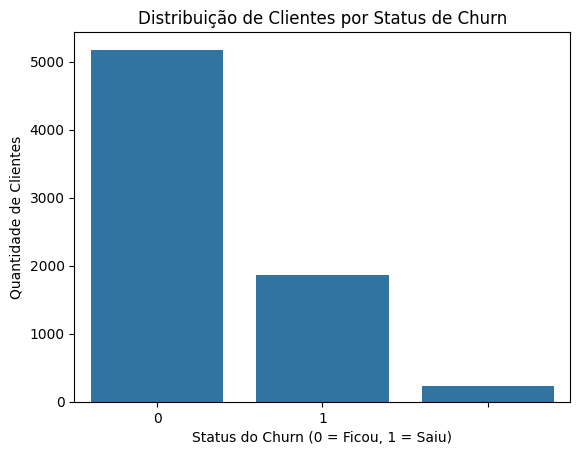

#### **Análise por Variáveis Categóricas**

Investigamos como o churn se comporta em diferentes segmentos. O fator mais impactante encontrado foi o **tipo de contrato**. O visual abaixo deixa claro que clientes com contrato **Mensal (`Month-to-month`)** representam a esmagadora maioria dos cancelamentos, enquanto contratos de longo prazo (1 ou 2 anos) garantem uma retenção muito maior.

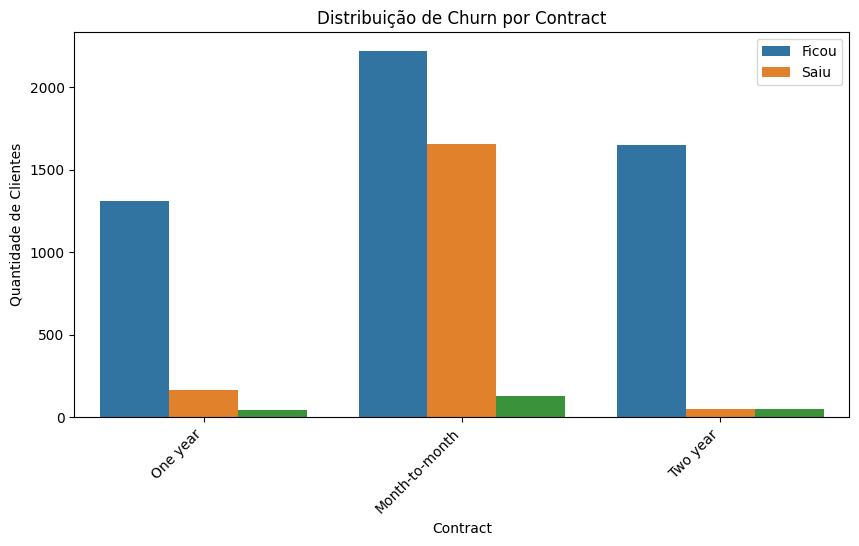

#### **Análise por Variáveis Numéricas**

Analisamos como as métricas numéricas se distribuem entre os clientes que ficaram e os que saíram. O **tempo de contrato (`tenure`)** se mostrou o indicador mais forte. O gráfico de caixa ilustra que clientes que cancelam (`Churn = 1`) possuem, em média, um tempo de contrato muito menor do que os clientes que permanecem.

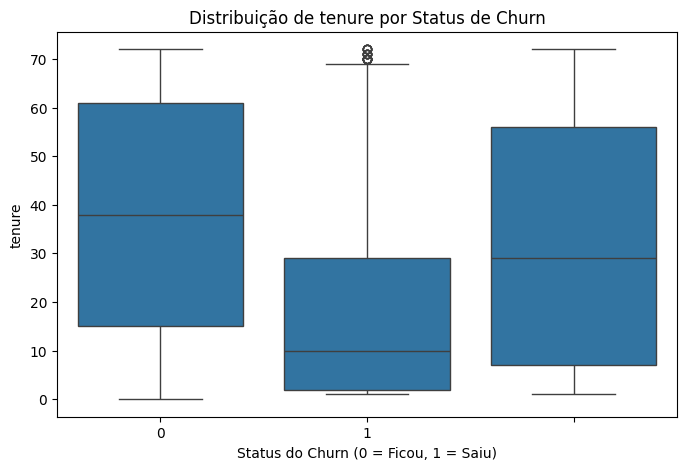

#### **Análise de Correlação**

A matriz de correlação nos permitiu visualizar a relação entre todas as variáveis numéricas simultaneamente. As cores mais fortes (próximas de 1 ou -1) indicam as relações mais significativas.

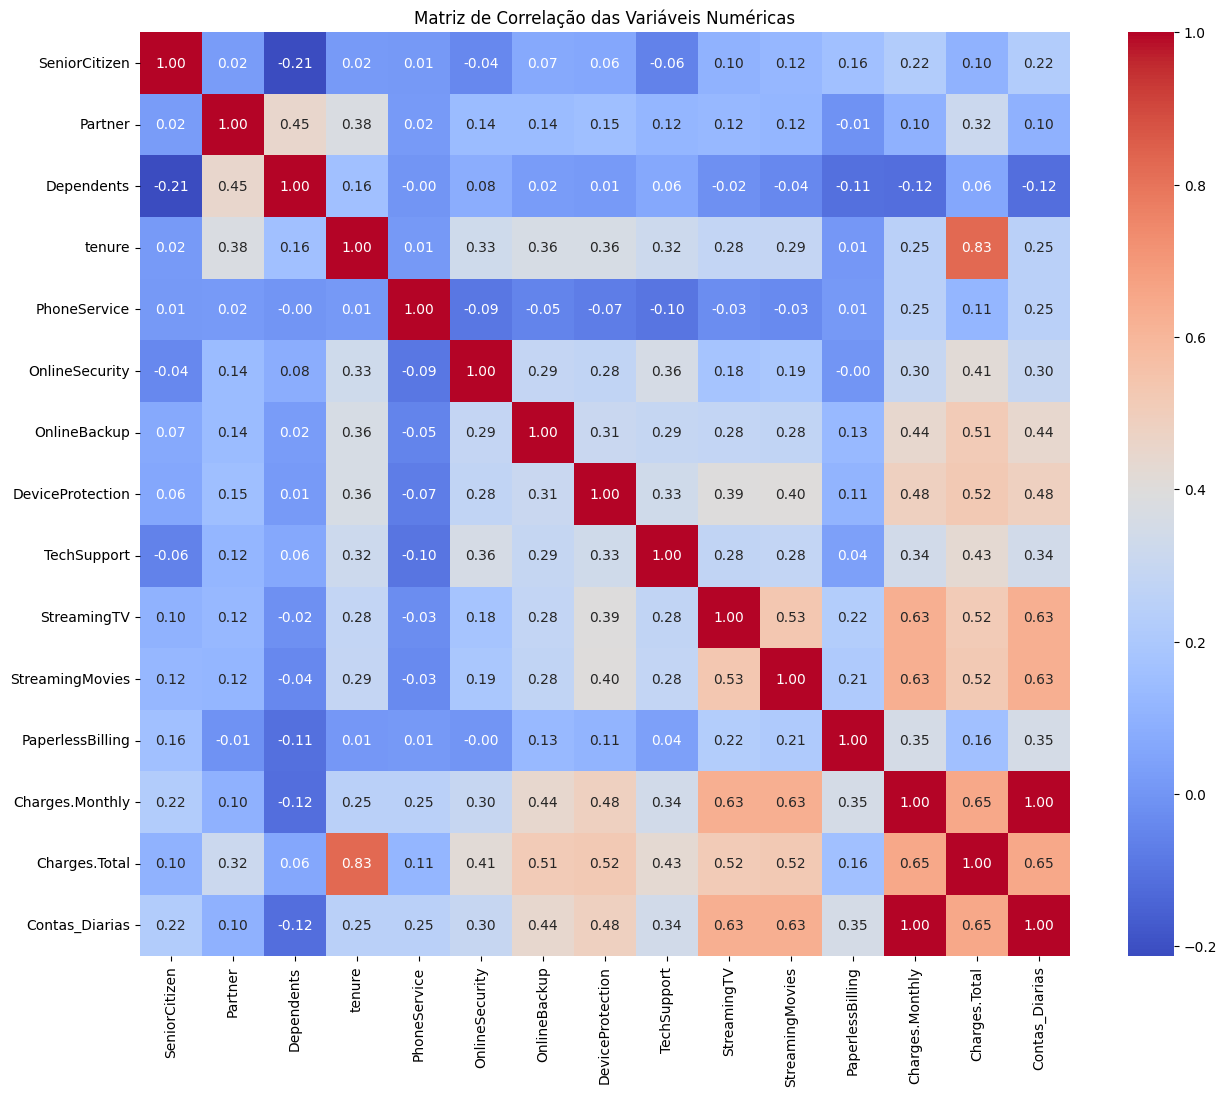

---

### **4. Conclusões e Insights**

* **O Perfil do Cliente que Evade:** O cliente com maior propensão a cancelar na Telecom X é aquele com **pouco tempo de casa (baixo `tenure`)** e um **contrato do tipo mensal (`Month-to-month`)**.
* **O Contrato Mensal é o Maior Vilão:** A flexibilidade do contrato mensal é uma "faca de dois gumes", sendo o principal ponto de saída para os clientes.
* **Os Primeiros Meses são Críticos:** A retenção de clientes nos estágios iniciais do seu ciclo de vida é fundamental para a saúde do negócio a longo prazo, como mostra a forte correlação negativa entre `tenure` e `Churn`.
* **Fatores Financeiros:** Cobranças mensais mais elevadas (`MonthlyCharges`) também estão positivamente correlacionadas com o churn, indicando que o preço é um fator relevante na decisão de cancelamento.

---

### **5. Recomendações**

Com base nos insights gerados, sugerimos as seguintes ações estratégicas para a Telecom X:

1.  **Foco na Migração de Contratos:** Criar campanhas ativas e com benefícios claros (descontos, serviços adicionais) para incentivar os clientes de contrato `Month-to-month` a migrarem para planos de 1 ou 2 anos.
2.  **Desenvolver um Programa de Onboarding:** Implementar um programa de boas-vindas e acompanhamento para novos clientes durante os primeiros 3 a 6 meses. O objetivo é garantir que eles extraiam o máximo de valor dos serviços contratados, aumentando a percepção de benefício e fortalecendo o relacionamento inicial.
3.  **Ações Preditivas:** Utilizar os insights desta análise como base para a equipe de Data Science construir um **modelo de Machine Learning**. Esse modelo poderá prever, com alta acurácia, quais clientes individuais têm a maior probabilidade de cancelar, permitindo que a equipe de retenção atue de forma proativa e personalizada.